# Introduction

This notebook demonstrates the use of PanCAKE with the NIRCam coronagraphs, and contrasts PanCAKE with default Pandeia coronagraphy calculations. In particular, it provides examples of:

* Constructing a NIRCam scene in both Pandeia and PanCAKE
* Importing a NIRCam scene built in Pandeia into PanCAKE
* Engine calculations using Pandeia's precomputed PSF library, in both Pandeia and PanCAKE
* Comparisons of Pandeia's precomputed PSF library with PanCAKE's on-the-fly PSF generation
* Comparisons of on-the-fly PSF generation with varying numbers of wavelength bins

In [1]:
# Note that this is currently suppressing warnings that are associated with pandeia.
# These are issues that the pandeia developers know about and are working on fixing.
# They're being suppressed simply because they're not relevant to the point of this notebook.
import warnings
from astropy.utils.exceptions import AstropyDeprecationWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=AstropyDeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

import jwst_pancake as pancake

from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.perform_calculation import perform_calculation

from copy import deepcopy
import numpy as np
import time

# Constructing a Scene

We'll start by defining the source and instrument properties for our desired observation. 

In [2]:
target_mV = 10.
ref_mV = 9.

target_Sp = 'a5v'
ref_Sp = 'a3v'

planet_a_mag = 17.0
planet_b_mag = 16.5

subarray = 'sub640'
filter_c = 'f210m'
mask_c = 'mask210r'

Now we'll load in a NIRCam template and configure the instrument for our observation.

Now we'll create a NIRCam template from Pandeia and configure the instrument for our observation. (In this case, it's already configured for an F210M observation, but we'll demonstrate setting the calculation keys regardless.)

In [3]:
# Load the template
config = build_default_calc('jwst', 'nircam', 'coronagraphy')

# Set the coronagraph and filter
config['configuration']['detector']['subarray'] = subarray
config['configuration']['instrument']['aperture'] = mask_c
config['configuration']['instrument']['filter'] = filter_c

This template contains a scene with a single star. We'll set the star properties and then duplicate it to create a planetary companion.

In [4]:
# Pull out the target (the first entry in the 'scene' list)
targetstar = config['scene'][0]
targetstar['spectrum']['normalization']['type'] = 'photsys'
targetstar['spectrum']['normalization']['norm_flux'] = target_mV
targetstar['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
targetstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
del targetstar['spectrum']['normalization']['norm_wave'] # not needed for bandpass
del targetstar['spectrum']['normalization']['norm_waveunit'] # not needed for bandpass
targetstar['spectrum']['sed']['key'] = target_Sp
targetstar['id'] = 1 #each source must have a unique ID, starting at 1

# Copy the target star and turn it into a planet
planetA = deepcopy(targetstar)
planetA['id'] = 2 #each source must have a unique ID, starting at 1

# A different way to normalize source flux
planetA['spectrum']['normalization']['bandpass'] = 'nircam,sw_imaging,f210m'
planetA['spectrum']['normalization']['norm_flux'] = planet_a_mag
planetA['spectrum']['normalization']['type'] = 'jwst'
planetA['spectrum']['sed']['sed_type'] = 'blackbody'
planetA['spectrum']['sed']['temp'] = 900.
del planetA['spectrum']['sed']['key'] #unnecessary now

# Source offset
planetA['position']['x_offset'] = 0.406 #arcsec
planetA['position']['y_offset'] = -1.263

# Copy that planet and turn it into a second, slightly brighter planet
planetB = deepcopy(planetA)
planetB['id'] = 3
planetB['position']['x_offset'] = -0.306 #arcsec
planetB['position']['y_offset'] = -.53
planetB['spectrum']['normalization']['norm_flux'] = planet_b_mag

# Update calculation file with the new planet
config['scene'].extend([planetA,planetB])

Create the reference scene for PSF subtraction

In [5]:
# We adopt a brighter but spectrally-mismatched reference
config['strategy']['psf_subtraction_source'] = deepcopy(targetstar)
config['strategy']['psf_subtraction_source']['spectrum']['normalization']['norm_flux'] = ref_mV
config['strategy']['psf_subtraction_source']['spectrum']['sed']['key'] = ref_Sp
config['strategy']['psf_subtraction_source']['id'] = 4

And now we'll plot the two scenes we've constructed

(0, 5.0)

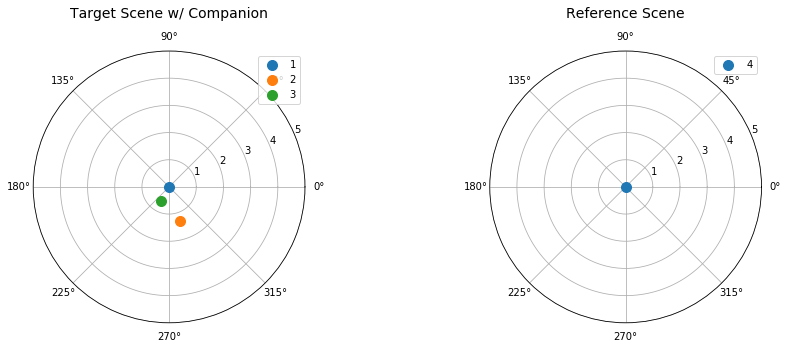

In [6]:
# The plot_scene convenience functions expect a scene to have a list of sources, whereas the PSF subtraction source
# in a pandeia configuration dictionary is a single source, and not part of a list.
reference = {}
reference['scene'] = [config['strategy']['psf_subtraction_source']]

plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
pancake.scene.plot_scene(config['scene'],'Target Scene w/ Companion',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
pancake.scene.plot_scene(reference['scene'],'Reference Scene',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)

# Run the Pandeia Engine

Now we pass our calculation files to the pandeia engine to create the slope images (and a number of other products).

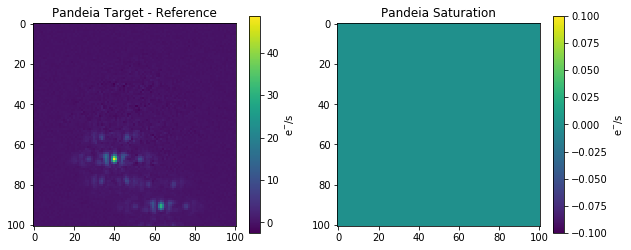

In [7]:
pandeia_result = perform_calculation(deepcopy(config))

subtracted_slope = pandeia_result['2d']['detector']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(pandeia_result['2d']['detector'])
plt.title('Pandeia Target - Reference')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(pandeia_result['2d']['saturation'])
plt.title('Pandeia Saturation')
plt.colorbar().set_label('e$^{-}$/s')

In order to run the same calculation via panCAKE, the convenience function ``engine.calculate_subtracted`` will generate similar results to Pandeia's optimally-subtracted calculation:

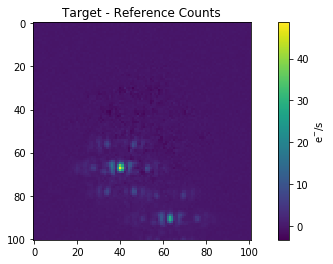

In [8]:
pancake_result = pancake.engine.calculate_subtracted(config)

subtracted_slope = pancake_result['subtracted']

plt.figure(figsize=(10,4))
plt.imshow(subtracted_slope)
plt.title('Target - Reference Counts')
plt.colorbar().set_label('e$^{-}$/s')

To demonstrate the difference between the two data reductions, the following plot shows the result of subtracting the panCAKE image from the pandeia image.

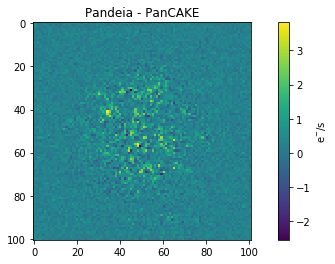

In [9]:
difference_image = pandeia_result['2d']['detector'] - pancake_result['subtracted']

plt.figure(figsize=(10,4))
plt.imshow(difference_image)
plt.title('Pandeia - PanCAKE')
plt.colorbar().set_label('e$^{-}$/s')

In this case, both results are quite close.

### Wave Sampling

An aside on performance and accuracy: The ```engine.options.wave_sampling``` parameter provides a hook into the wavelength sampling of the 3D (x,y,wavelength) cube. By default, Pandeia adopts some large value for the wavelength sampling (typically 150+); however, this is the primary time sink in the calculation. Setting ```engine.options.wave_sampling = 11``` while developing your simulation provides dramatic time savings while getting within ~5% of the "true" value. By ```engine.options.wave_sampling = 41```, one can expect agreement to within roughly 1%.

### On-the-fly PSF Calculations

The Pandeia engine relies on a library of precomputed PSFs that are sparsely sampled across the coronagraphic field of view. For the MIRI coronagraphs, this sparse sampling will often be insufficient for accurately capturing PSF variations arising from small offsets.

Pandeia-Coronagraphy gives the option (```engine.options.on_the_fly_PSFs```) to circumvent the use of this precomputed library and force recomputing each PSF on the fly in WebbPSF. We'll toggle it to True, at the cost of some speed.

The example below shoes a calculation with 11 data points (using on-the-fly PSFs), and one with 51.

In [ ]:
# Store the existing option values
pancake_options = pancake.engine.options
pancake_options.save_options()

# Turn on on-the-fly PSFs
pancake_options.on_the_fly_PSFs = True

# 11-bin PSF calculation, including required time
start_11 = time.time()
pancake_options.wave_sampling = 11
pancake_result_11 = pancake.engine.calculate_subtracted(config)
subtracted_slope_11 = pancake_result_11['subtracted']
print("11-point On-the-fly result completed in {:.1f} seconds".format(time.time() - start_11))

# 51-bin PSF calculation, including required time
start_51 = time.time()
pancake_options.wave_sampling = 51
pancake_result_51 = pancake.engine.calculate_subtracted(config)
subtracted_slope_51 = pancake_result_51['subtracted']
print("51-point On-the-fly result completed in {:.1f} seconds".format(time.time() - start_51))

# Restore initial option values
pancake_options.restore_options()

# Plot output
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(subtracted_slope_11)
plt.title('11 Wavelength Bins')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(subtracted_slope_51)
plt.title('51 Wavelength Bins')
plt.colorbar().set_label('e$^{-}$/s')

11-point On-the-fly result completed in 1698.6 seconds


Once again, we can compare these results both to one another and to the pandeia result above. In the plots below, the leftmost plot compares the 11- and 51-bin results, whilst the rightmost plot compares the 11-bin result to the pandeia result.

In [ ]:
sub_11_51 = pancake_result_11['subtracted'] - pancake_result_51['subtracted']
sub_11_pandeia = pandeia_result['2d']['detector'] - pancake_result_11['subtracted']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(sub_11_51)
plt.title('11-bin - 51-bin')
plt.colorbar().set_label('e${-}$/s')
plt.subplot(122)
plt.imshow(sub_11_pandeia)
plt.title('pandeia - 11-bin')
plt.colorbar().set_label('e${-}$/s')

In both cases, the results are roughly comparable.

The capabilities of on-the-fly PSF calculations are most apparent when target acquisition (TA) errors are included in the calculation. Although the ```engine.calculate_subtracted``` function offers the abilities to compute TA errors itself, in this case we will add the TA errors directly to the observed scene so that the same errors will be shown in both pandeia and pancake.

In [ ]:
config_with_errors = deepcopy(config)
target_x_err, target_y_err = scene.get_ta_error()
scene.offset_scene(config_with_errors['scene'], target_x_err, target_y_err)
reference_x_err, reference_y_err = scene.get_ta_error()
scene.offset_scene([config_with_errors['strategy']['psf_subtraction_source']], reference_x_err, reference_y_err)

pandeia_result_with_errors = pandeia_calculation(deepcopy(config_with_errors))

# Store the existing option values
past_psf = engine.options.on_the_fly_PSFs
past_wave_samples = engine.options.wave_sampling

engine.options.on_the_fly_PSFs = True
engine.options.wave_sampling = 21
pancake_result_with_errors = engine.calculate_subtracted(config_with_errors)

# Restore initial option values
engine.options.on_the_fly_PSFs = past_psf
engine.options.wave_sampling = past_wave_samples

pandeia_slope = pandeia_result_with_errors['2d']['detector']
pancake_slope = pancake_result_with_errors['subtracted']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(pandeia_slope)
plt.title('Pandeia Target Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(pancake_slope)
plt.title('PanCAKE Target Image')
plt.colorbar().set_label('e$^{-}$/s')

In [ ]:
config_target = deepcopy(config)
config_target['strategy']['psf_subtraction'] = 'target_only'
config_target_errors = deepcopy(config_target)
target_x_err, target_y_err = scene.get_ta_error()
print("Applying error ({}, {}) mas to target".format(target_x_err*1000, target_y_err*1000))
scene.offset_scene(config_target_errors['scene'], target_x_err, target_y_err)
reference_x_err, reference_y_err = scene.get_ta_error()
print("Applying error ({}, {}) mas to reference".format(reference_x_err*1000, reference_y_err*1000))
scene.offset_scene([config_target_errors['strategy']['psf_subtraction_source']], reference_x_err, reference_y_err)

pandeia_target_centred = pandeia_calculation(deepcopy(config_target))
print("Calculated Pandeia scene without errors")
pandeia_target_errored = pandeia_calculation(deepcopy(config_target_errors))
print("Calculated Pandeia scene with errors")

# Store the existing option values
past_psf = engine.options.on_the_fly_PSFs
past_wave_samples = engine.options.wave_sampling

engine.options.on_the_fly_PSFs = True
engine.options.wave_sampling = 11
pancake_centred = engine.calculate_subtracted(config)
print("Calculated pancake scene without errors")
pancake_errored = engine.calculate_subtracted(config_with_errors)
print("Calculated pancake scene with errors")

# Restore initial option values
engine.options.on_the_fly_PSFs = past_psf
engine.options.wave_sampling = past_wave_samples

In [ ]:
pandeia_slope_centred = pandeia_target_centred['2d']['detector']
pandeia_slope_errored = pandeia_target_errored['2d']['detector']
pandeia_slope_subtracted = pandeia_slope_centred - pandeia_slope_errored

plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(pandeia_slope_centred)
plt.title('Pandeia Centred Target')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(pandeia_slope_errored)
plt.title('Pandeia Target with Error')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(pandeia_slope_subtracted)
plt.title('Difference Image')
plt.colorbar().set_label('Residual e$^{-}$/s')
plt.savefig('pandeia.png')

In [ ]:
pancake_slope_centred = pancake_centred['target']
pancake_slope_errored = pancake_errored['target']
pancake_slope_subtracted = pancake_slope_centred - pancake_slope_errored

plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(pancake_slope_centred)
plt.title('PanCAKE Centred Target')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(pancake_slope_errored)
plt.title('PanCAKE Target with Error')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(pancake_slope_subtracted)
plt.title('Difference Image')
plt.colorbar().set_label('Residual e$^{-}$/s')
plt.savefig('pancake.png')